# Proyecto 1 Etapa 1 | FakeNews

In [1]:
!pip install contractions

In [69]:
import pandas as pd
import numpy as np
import re, string, unicodedata
import contractions
import inflect
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
# Cargar dataset
df_news = pd.read_csv('fake_news_spanish.csv', sep=';', encoding='utf-8', index_col=0)



In [4]:
# Eliminar valores nulos
df_news = df_news.dropna()

# Eliminar duplicados
df_news = df_news.drop_duplicates()

# Expandir contracciones
df_news['Descripcion'] = df_news['Descripcion'].apply(contractions.fix)

df_news.info()



<class 'pandas.core.frame.DataFrame'>
Index: 56602 entries, ID to ID
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Label        56602 non-null  int64 
 1   Titulo       56602 non-null  object
 2   Descripcion  56602 non-null  object
 3   Fecha        56602 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.2+ MB


Limpieza de datos

In [5]:
 def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
          new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
          new_words.append(new_word)
    return new_words

In [6]:
def to_lowercase(words):
    return [word.lower() for word in words]

In [7]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

In [8]:
def replace_numbers(words):
   """Replace all interger occurrences in list of tokenized words with textual representation"""
   p = inflect.engine()
   new_words = []
   for word in words:
       if word.isdigit():
           new_word = p.number_to_words(word)
           new_words.append(new_word)
       else:
           new_words.append(word)
   return new_words

In [9]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
stop_words = nltk.corpus.stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
def remove_stopwords(words):
    return [word for word in words if word not in stop_words]

In [11]:
def preprocess_text(words):
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = remove_non_ascii(words)
    words = replace_numbers(words)
    return words

Tokenización

In [12]:
df_news['Descripcion'] = df_news['Descripcion'].apply(contractions.fix)

In [13]:
df_news['words'] = df_news['Descripcion'].apply(word_tokenize)
df_news.head()

,Label,Titulo,Descripcion,Fecha,words
ID,,,,,
ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,"[El, diario, británico, publicó, este, pasado,..."
ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,"[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE..."
ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,"[El, valencianismo, convoca, en, Castelló, su,..."
ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,"[En, política, ,, igual, que, hay, que, negoci..."
ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,"[En, una, entrevista, en, El, Punt, Avui, ,, e..."


In [14]:
df_news['words'].dropna()

,words
ID,
ID,"[El, diario, británico, publicó, este, pasado,..."
ID,"[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE..."
ID,"[El, valencianismo, convoca, en, Castelló, su,..."
ID,"[En, política, ,, igual, que, hay, que, negoci..."
ID,"[En, una, entrevista, en, El, Punt, Avui, ,, e..."
...,...
ID,"[El, gobierno, regional, han, indicado, que, l..."
ID,"[Si, la, higiene, democrática, nos, lleva, a, ..."
ID,"[El, coordinador, federal, de, IU, asegura, qu..."


In [15]:
df_news["words1"] = df_news["words"].apply(preprocess_text)
df_news.head()

,Label,Titulo,Descripcion,Fecha,words,words1
ID,,,,,,
ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,"[El, diario, británico, publicó, este, pasado,...","[diario, britanico, publico, pasado, jueves, e..."
ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,"[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE...","[revelan, gobierno, negocio, liberacion, mirel..."
ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,"[El, valencianismo, convoca, en, Castelló, su,...","[valencianismo, convoca, castello, fiesta, gra..."
ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,"[En, política, ,, igual, que, hay, que, negoci...","[politica, igual, negociar, empresarios, negoc..."
ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,"[En, una, entrevista, en, El, Punt, Avui, ,, e...","[entrevista, punt, avui, lider, jxcat, desdram..."


In [16]:
def stem_words(words):
    stemmer = SnowballStemmer("spanish")
    return [stemmer.stem(word) for word in words]

In [17]:
def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

In [18]:
print(df_news['words'].sample(5))

ID
ID    [Hace, menos, de, medio, siglo, la, pena, de, ...
ID    [El, hospital, de, Ifema, fue, la, construcció...
ID    [Te, proponemos, cinco, noticias, para, que, e...
ID    [El, ministro, de, Exteriores, ha, asistido, a...
ID    [El, presidente, del, Gobierno, presume, en, e...
Name: words, dtype: object


In [19]:
def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas
    return words

df_news['words'] = df_news['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.

In [20]:
# Convertir lista de palabras a texto
df_news['words'] = df_news['words'].apply(lambda x: ' '.join(map(str, x)))
df_news.head()

,Label,Titulo,Descripcion,Fecha,words,words1
ID,,,,,,
ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,el diari britan public este pas juev un editor...,"[diario, britanico, publico, pasado, jueves, e..."
ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,revel que el gobiern negoci la liber de mirel ...,"[revelan, gobierno, negocio, liberacion, mirel..."
ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,el valencian convoc en castell su fiest grand ...,"[valencianismo, convoca, castello, fiesta, gra..."
ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,"en polit , igual que hay que negoci con los em...","[politica, igual, negociar, empresarios, negoc..."
ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,"en una entrev en el punt avui , el lid de jxca...","[entrevista, punt, avui, lider, jxcat, desdram..."


Vectorización

In [21]:
# Variables predictoras y objetivo
X_data, y_data = df_news['words'], df_news['Label']

# Vectorización con TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000,stop_words=stop_words)


In [22]:
X_vect = vectorizer.fit_transform(X_data)

In [23]:
tfidf_df = pd.DataFrame(X_vect.toarray(),columns=vectorizer.get_feature_names_out())
tfidf_df.head()

,000,10,100,11,12,13,14,15,16,17,...,vivienda,volv,vot,votacion,voto,votos,vox,víctimas,último,últimos
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.040799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(tfidf_df, y_data, test_size=0.2, random_state=0)

Entrenamiento de modelo (Decision Tree)

In [47]:
# Entrenamiento del modelo
arbol = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)

In [48]:
# Ajuste del modelo
arbol = arbol.fit(X_train, Y_train)

In [49]:
y_pred = arbol.predict(X_test)

In [50]:
cm = confusion_matrix(Y_test, y_pred)

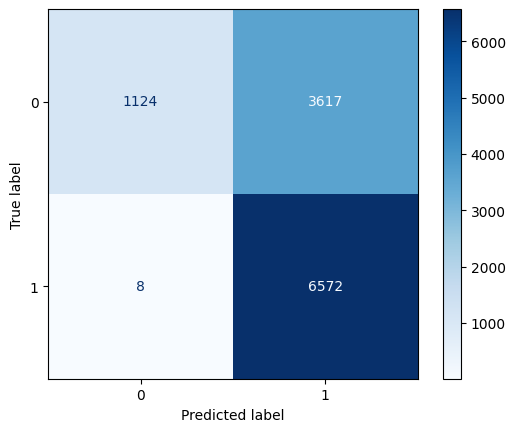

In [51]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=arbol.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [52]:
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test,y_pred)))
print("Precisión: {}".format(precision_score(Y_test,y_pred)))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred)))

Exactitud: 0.68
Recall: 0.9987841945288753
Precisión: 0.6450093237805476
Puntuación F1: 0.7838273003756933


In [53]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.24      0.38      4741
           1       0.65      1.00      0.78      6580

    accuracy                           0.68     11321
   macro avg       0.82      0.62      0.58     11321
weighted avg       0.79      0.68      0.62     11321



In [54]:
# Evaluación del modelo
y_pred = arbol.predict(X_train)
print('Exactitud: %.2f' % accuracy_score(Y_train, y_pred))
print("Recall: {}".format(recall_score(Y_train,y_pred)))
print("Precisión: {}".format(precision_score(Y_train,y_pred)))
print("Puntuación F1: {}".format(f1_score(Y_train,y_pred)))

Exactitud: 0.68
Recall: 0.99919718632923
Precisión: 0.6439746716929066
Puntuación F1: 0.7831897520413514


Entrenamiento de modelo (KNN)

In [56]:
#Create new KNN object
knn = KNeighborsClassifier(n_neighbors=3)

#Fit the model
knn = knn.fit(X_train, Y_train)

In [76]:
y_pred = knn.predict(X_test)

In [77]:
cm = confusion_matrix(Y_test, y_pred)

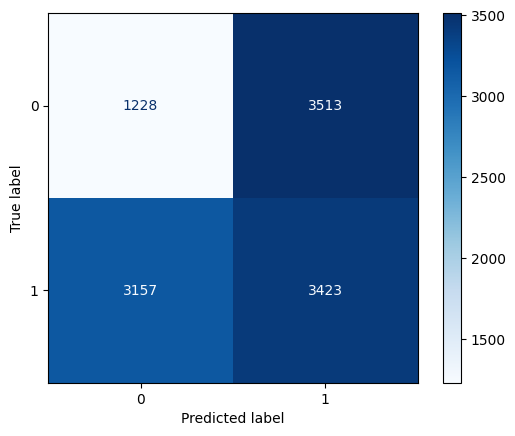

In [78]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [79]:
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test,y_pred)))
print("Precisión: {}".format(precision_score(Y_test,y_pred)))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred)))

Exactitud: 0.41
Recall: 0.5202127659574468
Precisión: 0.4935121107266436
Puntuación F1: 0.5065108020124297


In [80]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.28      0.26      0.27      4741
           1       0.49      0.52      0.51      6580

    accuracy                           0.41     11321
   macro avg       0.39      0.39      0.39     11321
weighted avg       0.40      0.41      0.41     11321



In [81]:
# Evaluación del modelo
y_pred = arbol.predict(X_train)
print('Exactitud: %.2f' % accuracy_score(Y_train, y_pred))
print("Recall: {}".format(recall_score(Y_train,y_pred)))
print("Precisión: {}".format(precision_score(Y_train,y_pred)))
print("Puntuación F1: {}".format(f1_score(Y_train,y_pred)))

Exactitud: 0.68
Recall: 0.99919718632923
Precisión: 0.6439746716929066
Puntuación F1: 0.7831897520413514


Entrenamiento de modelo (Random Forest)

In [70]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [72]:
rf.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [82]:
y_pred = rf.predict(X_test)

In [83]:
cm = confusion_matrix(Y_test, y_pred)

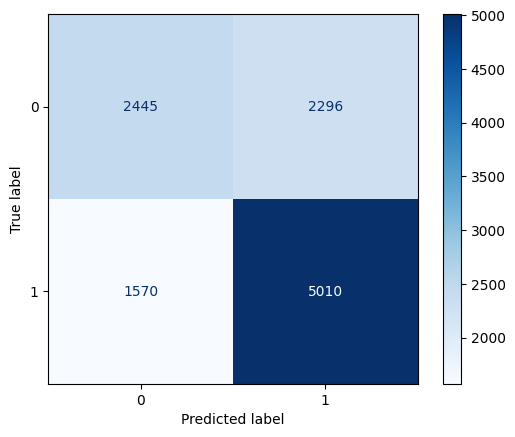

In [84]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [85]:
print('Exactitud: %.2f' % accuracy_score(Y_test, y_pred))
print("Recall: {}".format(recall_score(Y_test,y_pred)))
print("Precisión: {}".format(precision_score(Y_test,y_pred)))
print("Puntuación F1: {}".format(f1_score(Y_test,y_pred)))

Exactitud: 0.66
Recall: 0.7613981762917933
Precisión: 0.6857377497946893
Puntuación F1: 0.7215900907388737


In [86]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.52      0.56      4741
           1       0.69      0.76      0.72      6580

    accuracy                           0.66     11321
   macro avg       0.65      0.64      0.64     11321
weighted avg       0.65      0.66      0.65     11321



In [87]:
# Evaluación del modelo
y_pred = arbol.predict(X_train)
print('Exactitud: %.2f' % accuracy_score(Y_train, y_pred))
print("Recall: {}".format(recall_score(Y_train,y_pred)))
print("Precisión: {}".format(precision_score(Y_train,y_pred)))
print("Puntuación F1: {}".format(f1_score(Y_train,y_pred)))

Exactitud: 0.68
Recall: 0.99919718632923
Precisión: 0.6439746716929066
Puntuación F1: 0.7831897520413514


Exportación del mejor modelo

In [ ]:
# Actualizar el feature array
feature_array = tfidf_vectorizer.get_feature_names_out()

# Top 10 palabras de cada grupo
top_n = 10  # Número de palabras más importantes

for ods in data['sdg'].unique():
    ods_texts = data[data['sdg'] == ods]['Textos_espanol_clean']
    ods_tfidf = tfidf_vectorizer.transform(ods_texts)
    avg_tfidf_weights = ods_tfidf.mean(axis=0).A1
    top_features_idx = np.argsort(avg_tfidf_weights)[-top_n:]
    top_features = feature_array[top_features_idx]
    print(f"Palabras clave para ODS {ods}: {top_features}")